In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

## GET AVERAGE RETURNS OVER TIME OF THE AVAILABLE FUNDS

In [2]:
# Connection to WRDS
import wrds
db = wrds.Connection(wrds_username='etiennebruno')

Loading library list...
Done


In [3]:
# Import CIKs from the dataframe of all cleaned filings
from utils import *
ciks = ', '.join(list(df_from_filings().cik.unique()))

In [4]:
# Get all cik number available (intersection between our dataframe and the data on CRSP)
ciks_data = db.raw_sql(f'''
        select distinct comp_cik
        from crsp_q_mutualfunds.crsp_cik_map
        where comp_cik in ({ciks})
''')
cik_available = list(ciks_data.comp_cik)
cik_available = ', '.join([str(i) for i in cik_available])

In [5]:
# With the mapping table of CRSP, get all companies' fund number
crsp_fundno_available = db.raw_sql(f'''
        select *
        from crsp_q_mutualfunds.crsp_cik_map
        where comp_cik in ({cik_available})
''')
crsp_fundno_available

,crsp_fundno,comp_cik,series_cik,contract_cik
0,3569.0,1830437.0,S000074043,C000231400
1,3691.0,1576367.0,S000013666,C000037424
2,3966.0,1707560.0,S000066202,C000213944
3,5463.0,1650149.0,S000054431,C000170953
4,5669.0,1750821.0,S000070728,C000224837
...,...,...,...,...
1782,99514.0,1587551.0,S000074761,C000232932
1783,99591.0,1810747.0,S000075090,C000233895
1784,99710.0,1587551.0,S000060087,C000206947
1785,99711.0,1587551.0,S000060087,C000225339


In [6]:
# Convert the list of fund numbers to a list of string type for future SQL queries
list_float_fundnos = list(crsp_fundno_available.crsp_fundno.unique())
crsp_fundno_available_list_str = ', '.join([str(i) for i in list_float_fundnos])

In [7]:
# Get all available returns for each fund
monthly_returns_all_funds = db.raw_sql(f'''
        select *
        from crsp_q_mutualfunds.monthly_returns
        where crsp_fundno in ({crsp_fundno_available_list_str})
        order by caldt desc
''')
monthly_returns_all_funds

,crsp_fundno,caldt,mret
0,88660.0,2022-03-31,0.025914
1,6172.0,2022-03-31,-0.028180
2,59199.0,2022-03-31,-0.011579
3,90323.0,2022-03-31,-0.005836
4,87870.0,2022-03-31,0.021689
...,...,...,...
90891,10962.0,1962-04-30,-0.045333
90892,10962.0,1962-03-30,NaN
90893,10962.0,1962-02-28,NaN
90894,10962.0,1962-01-31,NaN


In [8]:
# Create a new dataframe with some statistic and the average return
monthly_returns_all_funds_aggregated = monthly_returns_all_funds[['caldt', 'mret']].groupby('caldt').agg(
    count=('mret', 'count'),
    mret=('mret', 'mean'),
    mret_max=('mret', 'max'),
    mret_min=('mret', 'min'),
    mret_sdt=('mret', 'std'),
)

In [9]:
monthly_returns_all_funds_aggregated.reset_index(inplace=True)
monthly_returns_all_funds_aggregated['caldt'] = pd.to_datetime(monthly_returns_all_funds_aggregated['caldt'], format= '%Y-%m-%d')

In [10]:
monthly_returns_all_funds_aggregated = monthly_returns_all_funds_aggregated.loc[monthly_returns_all_funds_aggregated['caldt'] >= '2000-01-01']
monthly_returns_all_funds_aggregated

,caldt,count,mret,mret_max,mret_min,mret_sdt
457,2000-01-31,19,-0.024617,0.043946,-0.080595,0.035926
458,2000-02-29,19,0.032752,0.193975,-0.052006,0.076678
459,2000-03-31,19,0.020806,0.125203,-0.059077,0.048786
460,2000-04-28,19,-0.026431,0.003075,-0.107775,0.032489
461,2000-05-31,19,-0.015760,0.028455,-0.065211,0.027456
...,...,...,...,...,...,...
719,2021-11-30,1329,-0.020885,0.104516,-0.204944,0.024752
720,2021-12-31,1336,0.023558,0.160748,-0.231065,0.032606
721,2022-01-31,1355,-0.039980,0.268421,-0.250790,0.044322
722,2022-02-28,1357,-0.015859,0.146912,-0.405151,0.028031


## GET AVERAGE RETURNS OVER TIME OF TRADITIONNAL BENCHMARKS

In [11]:
index_return_query = db.raw_sql("""
    select  
    date,
    vwretd 
    from crsp.msi
    where 
    date>='2000-01-01'""", date_cols=['date']
    )

In [12]:
left = monthly_returns_all_funds_aggregated[['mret', 'caldt']]
right = index_return_query[['date', 'vwretd']]
cumulative_data = pd.merge(left=left, right=right, how='inner', left_on='caldt', right_on='date')

# Compute cumulative returns for both avg of funds and market
cumulative_data['cum_ret_funds'] = (1 + cumulative_data['mret']).cumprod() - 1
cumulative_data['cum_ret_mkt'] = (1 + cumulative_data['vwretd']).cumprod() - 1

## GRAPH OF AVERAGE RETURNS OVER TIME WITH BENCHMARKS

In [13]:
# Rename df for better modularity
data = monthly_returns_all_funds_aggregated.copy()

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style="darkgrid")
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set(rc={"figure.figsize":(18, 8)})

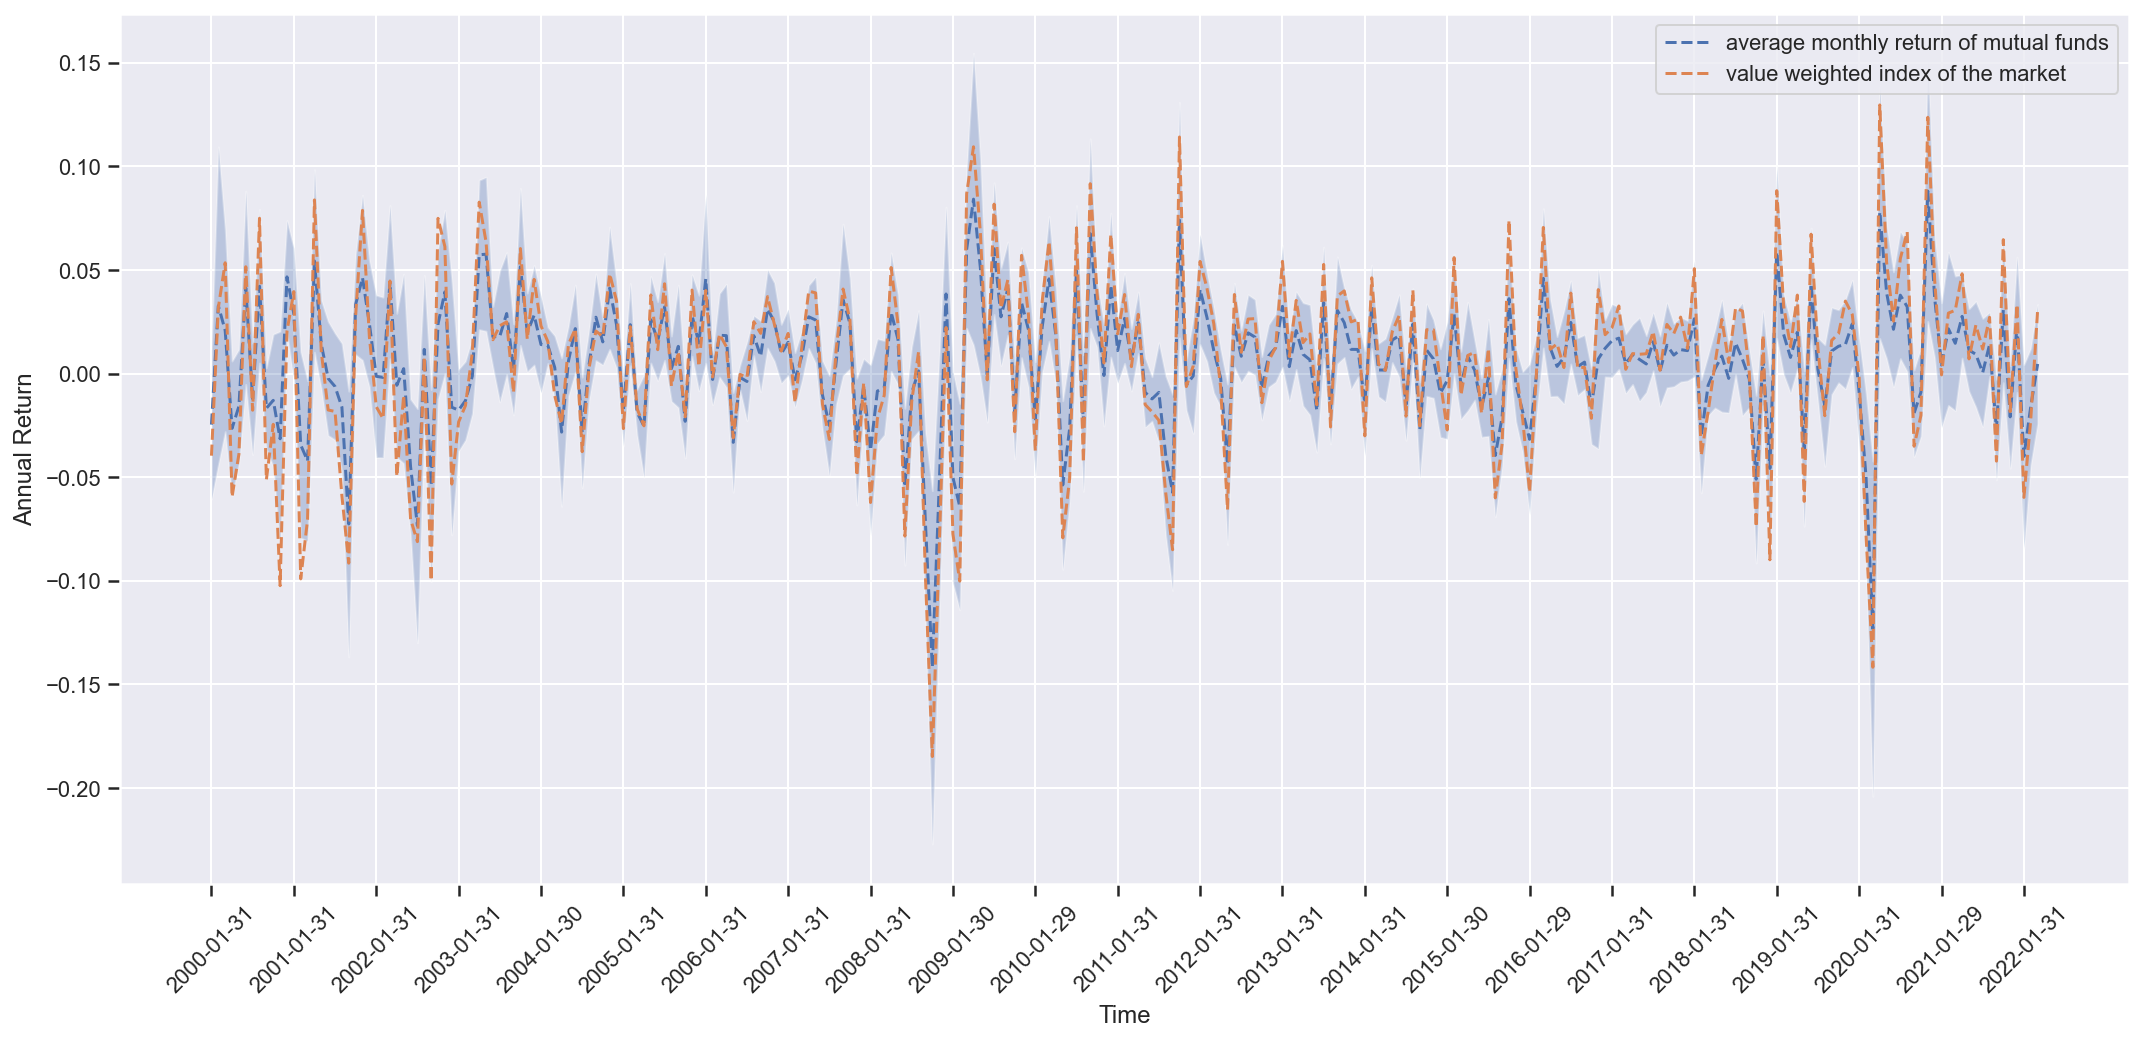

In [15]:
plt.tick_params(left=True,
                bottom=True,
                labelleft=True,
                labelbottom=True)

# Plot the average return of all mutual funds
X=data['caldt'].dt.strftime('%Y-%m-%d')
Y=data['mret']
sns.lineplot(x=X, y=Y, linestyle='--')

# Average Value Weighted Index - market
X=index_return_query['date'].dt.strftime('%Y-%m-%d')
Y=index_return_query['vwretd']
sns.lineplot(x=X, y=Y, linestyle='--')

lower_bound = data['mret'] + data['mret_sdt']
upper_bound = data['mret'] - data['mret_sdt']

plt.fill_between(X, lower_bound, upper_bound, alpha=.3)

plt.xlabel('Time')
plt.ylabel('Annual Return')
plt.xticks(X[::12], rotation=45)

plt.legend(['average monthly return of mutual funds', 'value weighted index of the market'])
#plt.savefig('annual_return_plots.png', dpi=200)
#plt.savefig('annual_return_plots_with_market.png', dpi=200)
plt.show()

### GET AND PLOT CUMULATIVE RETURNS

In [16]:
# Rename df for better modularity
data = cumulative_data.copy()

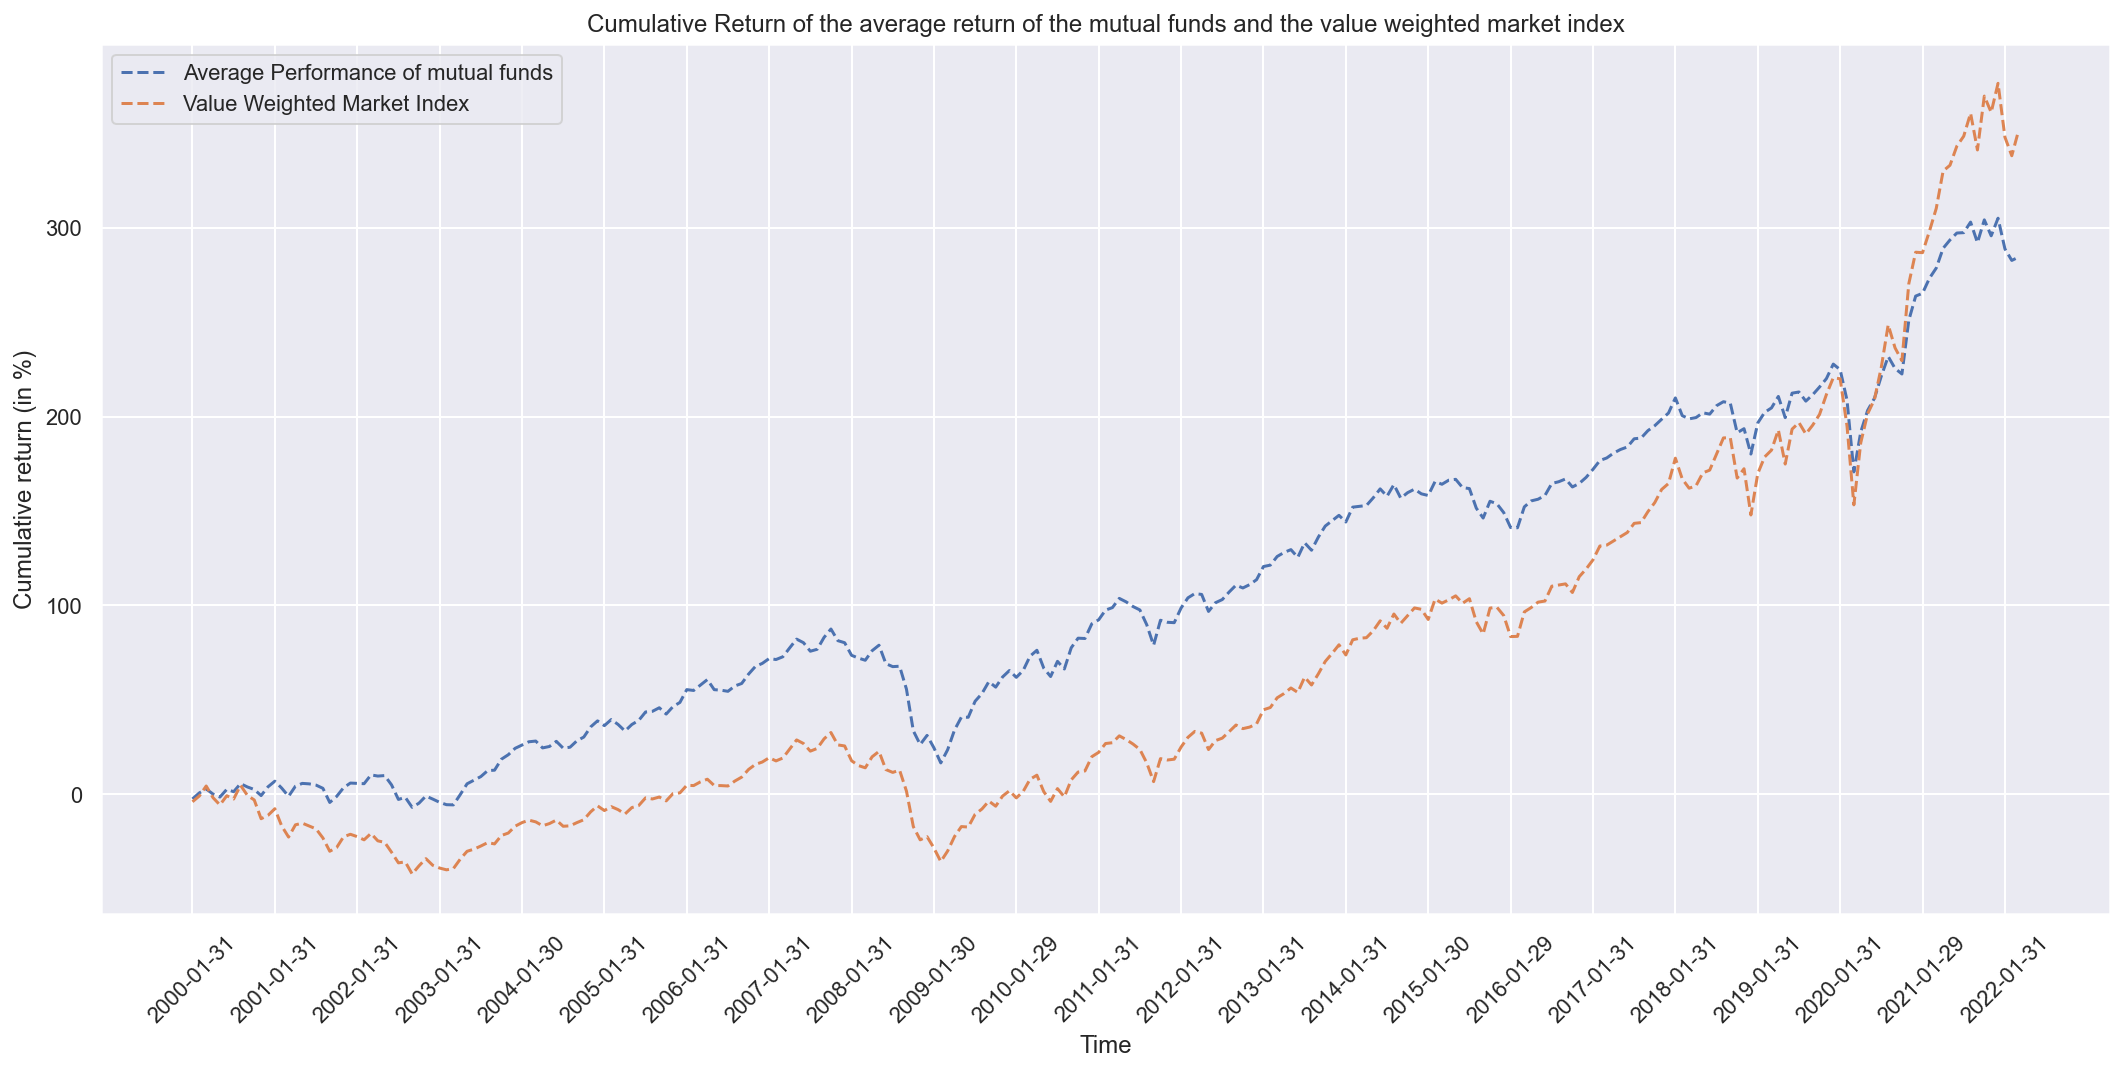

In [17]:
# Plot the cumulative return of all mutual funds
X=data['caldt'].dt.strftime('%Y-%m-%d')
Y=data['cum_ret_funds']*100
sns.lineplot(x=X, y=Y, linestyle='--')

# Cumulative Value Weighted index return - market
X=data['date'].dt.strftime('%Y-%m-%d')
Y=data['cum_ret_mkt']*100
sns.lineplot(x=X, y=Y, linestyle='--')

plt.xlabel('Time')
plt.ylabel('Cumulative return (in %)')
plt.title('Cumulative Return of the average return of the mutual funds and the value weighted market index')
plt.xticks(X[::12], rotation=45)

plt.legend(['Average Performance of mutual funds', 'Value Weighted Market Index'])
#plt.savefig('comparisons_with_vw_market.png', dpi=200)

plt.show()

## FIND VARIABLE NAME IN SCHEMA

In [ ]:
%%time
for table in db.list_tables(library='crsp'):
    try:
        l= list(filter(lambda x: ('crsp_fundno' in x) and ('cik' in x), db.get_table(library='crsp_q_mutualfunds', table=table, obs=1).keys()))
    except:
        pass
    if len(l) > 0:
        print(table, "---", l)

In [ ]:
%%time
for table in db.list_tables(library='crsp'):
    try:
        tab_keys = db.get_table(library='crsp_q_mutualfunds', table=table, obs=1).keys()
        l = list(filter(lambda x: 'cik' in x, tab_keys))
    except:
        pass
    if len(l) > 0:
        print(table, "---", l, tab_keys)

In [ ]:
%%time
for table in db.list_tables(library='crsp'):
    try:
        l= list(filter(lambda x: 'cik' in x, db.get_table(library='crsp', table=table, obs=1).keys()))
    except:
        pass
    if len(l) > 0:
        print(table, "---", l)

## TRY SOME QUERIES

In [ ]:
# Connection to WRDS
import wrds
db = wrds.Connection(wrds_username='etiennebruno')

In [ ]:
db.list_libraries().sort()
db.list_libraries()

In [ ]:
# List the tables of a given library
db.list_tables(library='crsp')

In [ ]:
# Get data
daily = db.get_table(library='crsp', table='fund_summary2', obs=10)

In [ ]:
# Get funds name over a given period
df_funds_map = db.raw_sql('''
        select distinct on (fund_name) fund_name, ticker, ncusip, cusip8
        from crsp.portnomap
        where begdt <= '2020-01-01' --and enddt >= '2022-01-01'
        order by fund_name asc
''')

In [ ]:
# Get funds name over containing some strings of the S&P 500
db.raw_sql('''
        select distinct fund_name
        from crsp.portnomap
        where lower(fund_name::text) LIKE '%%s&p%%'
            and lower(fund_name::text) LIKE '%%500%%'
            --and lower(fund_name::text) LIKE '%%bond%%'
            --and lower(fund_name::text) LIKE '%%national%%'
            --and caldt >= '2010-01-31'
     limit 100
''')

In [ ]:
db.raw_sql('''
        select *
        from crsp.fund_summary2
        where fund_name LIKE '%%FundVantage Trust: Gotham Enhanced S&P 500 Index Fund; Institutional Class Shares%%'
        --and caldt >= '2010-01-31'
''')

In [ ]:
db.raw_sql('''
        select *
        from crsp.portnomap
        where (fund_name::text) LIKE '%%FundVantage Trust: Gotham Enhanced S&P 500 Index Fund; Institutional Class Shares%%'
        --and caldt >= '2010-01-31'
''')

In [ ]:
db.raw_sql('''
        select crsp_fundno, count(mret), max(mret), avg(mret)
        from crsp_q_mutualfunds.monthly_tna_ret_nav
        group by crsp_fundno
        order by count(mret) desc
     limit 10
''')